In [1]:
import torch
import numpy as np
import lightning as L
from torch.utils.data import DataLoader
from TiDE.data import SimpleDataset, collate_fn
from lightning.pytorch.callbacks import ModelCheckpoint

from TiDE.pl_model import Model

torch.set_float32_matmul_precision('medium')

import joblib

x = torch.tensor(joblib.load('/root/git_code/TiDE/data/x_res.pkl').values).float()
y = torch.tensor(joblib.load('/root/git_code/TiDE/data/y_p_1000_h_0.pkl').values).float()

In [2]:

L_n = 50
H_n = 20
train_dataset = SimpleDataset(x[:int(x.shape[0]*0.9)], y[:int(x.shape[0]*0.9)], L_n, H_n)
val_dataset = SimpleDataset(x[int(x.shape[0]*0.9):], y[int(x.shape[0]*0.9):], L_n, H_n)

train_loader = DataLoader(dataset=train_dataset, collate_fn = collate_fn, num_workers = 32, shuffle=True, batch_size=512)
val_loader = DataLoader(dataset=val_dataset, collate_fn = collate_fn, num_workers = 32, shuffle=False, batch_size=2048)

model_config = dict(
    L=L_n, 
    H=H_n, 
    feature_dim=84, 
    feature_encode_dim=4, 
    decode_dim=16, 
    hidden_dim=256, 
    dropout=0.1, 
    bias=False
)

max_iters = 100_000

model = Model(
    model_config = model_config,
    lr = 1e-4,
    min_lr = 2e-5, 
    weight_decay = 0.1,
    warmup_iters = 1000,
    max_iters = max_iters,
    lr_strategy = 'cosine',
)


In [4]:
model = model.load_from_checkpoint('/root/git_code/TiDE/runs/lightning_logs/version_0/checkpoints/epoch=1-step=29544.ckpt')

In [14]:
labels = []
predictions = []

for batch in val_loader:
    batch = {k:v.cuda() for k,v in batch.items()}
    labels.append(batch['label'][:,0])
    with torch.no_grad():
        predictions.append(model(batch)[:,0])

In [18]:
label = torch.cat(labels, dim=-1)
prediction = torch.cat(predictions, dim=-1)

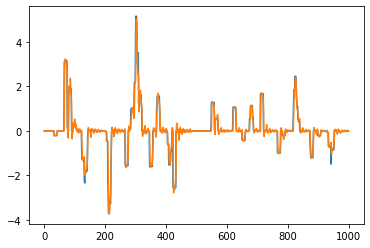

In [22]:
import matplotlib.pyplot as plt


plt.plot(label.detach().cpu().numpy()[:1000])
plt.plot(prediction.detach().cpu().numpy()[:1000])